## 1. Imports

In [2]:
import torch
# Download an example image from the pytorch website
import urllib
from PIL import Image as Image 
from torchvision import transforms
from IPython.display import Image as show_img
import numpy as np
import pandas as pd
from lime import lime_image
from skimage.segmentation import mark_boundaries, find_boundaries
import matplotlib.pyplot as plt
import cv2

## 2. Functions

In [3]:
def pre_process(lista, index):
    # remove directories
    lista = [item[index:] for item in lista]
    
    # remove digits
    lista = [re.sub(r'\b\d+\b', '', item) for item in lista]

    # remove hiffens 
    lista = [re.sub(r'\b-\b', ' ', item) for item in lista]

    # remove punctuation
    lista = [item.strip(string.punctuation) for item in lista]
    
    return lista

def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

def convert_bars(lista):
    lista = [item.replace('\\', '/') for item in lista]
    return lista

def files_in_folder(path):
    files = []
    for r, d, f in os.walk(path):
        for file in f:
            if '.jpg' in file:
                files.append(os.path.join(r, file))
    files = convert_bars(files)
    return files

def predict(pill_transf, preprocess_transform, image):
    input_tensor = preprocess_transform(pill_transf(image))
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)

    predicted = torch.nn.functional.softmax(output[0], dim=0).argmax()
    scores = torch.nn.functional.softmax(output[0], dim=0)
    y_hat = pd.read_csv('labels.csv',index_col = 'id').loc[int(predicted)+1].label
    return y_hat, predicted, scores

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    #batch =preprocess_transform(images).unsqueeze(0)
    logits = model(batch)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def output_image(img):
    img_gray = rgb2gray(img)    
    plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    plt.show()
    return img_gray

## 3. Load model

In [4]:
model = torch.hub.load('pytorch/vision:v0.4.2', 'mobilenet_v2', pretrained=True)
model.eval()

Using cache found in C:\Users\Asus/.cache\torch\hub\pytorch_vision_v0.4.2


MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

## 4. Examples of the 5 best classifications

In [5]:
pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

## 4.1. True label - harp; Predicted label - harp 

Prediction of MobileNet: harp


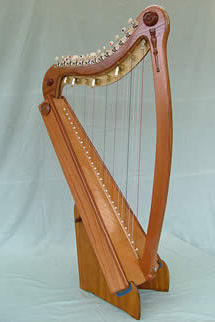

In [58]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/098.harp/098_0001.jpg"
input_image41 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image41)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

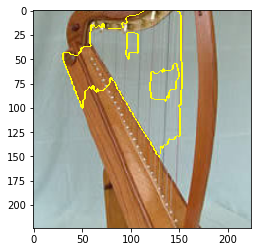

In [15]:
explainer = lime_image.LimeImageExplainer()
explanation41 = explainer.explain_instance(np.array(pill_transf(input_image41)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation41.get_image_and_mask(explanation41.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [202]:
temp, mask = explanation41.get_image_and_mask(explanation51.top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img41 = mark_boundaries(temp/255.0, mask)
output41 = output_image(img41)

NameError: name 'explanation41' is not defined

## 4.2. True label - harp ; Predicted label - harp

Prediction of MobileNet: harp


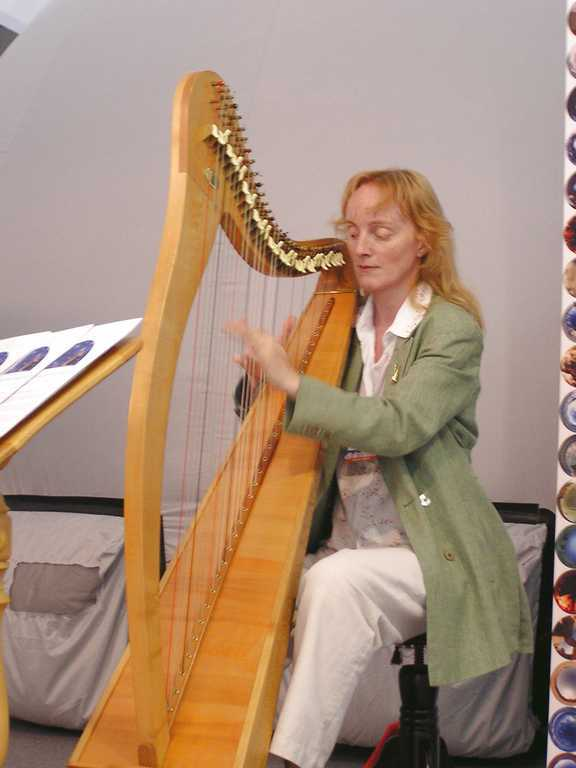

In [18]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/098.harp/098_0007.jpg"
input_image42 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image42)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

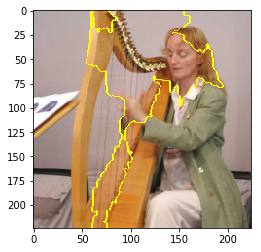

In [19]:
explainer = lime_image.LimeImageExplainer()
explanation42 = explainer.explain_instance(np.array(pill_transf(input_image42)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation42.get_image_and_mask(explanation42.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [ ]:
temp, mask = explanation42.get_image_and_mask(explanation51.top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img42 = mark_boundaries(temp/255.0, mask)
output42 = output_image(img42)

## 4.3. True label - harp ; Predicted label - harp

Prediction of MobileNet: harp


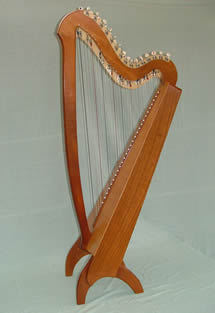

In [23]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/098.harp/098_0015.jpg"
input_image43 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image43)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

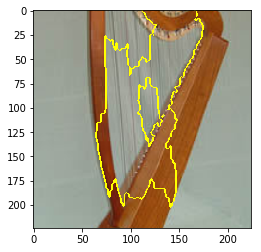

In [27]:
explainer = lime_image.LimeImageExplainer()
explanation43 = explainer.explain_instance(np.array(pill_transf(input_image43)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation43.get_image_and_mask(explanation43.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [ ]:
temp, mask = explanation43.get_image_and_mask(explanation51.top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img43 = mark_boundaries(temp/255.0, mask)
output43 = output_image(img43)

## 4.4. True label - harp ; Predicted label - harp

Prediction of MobileNet: harp


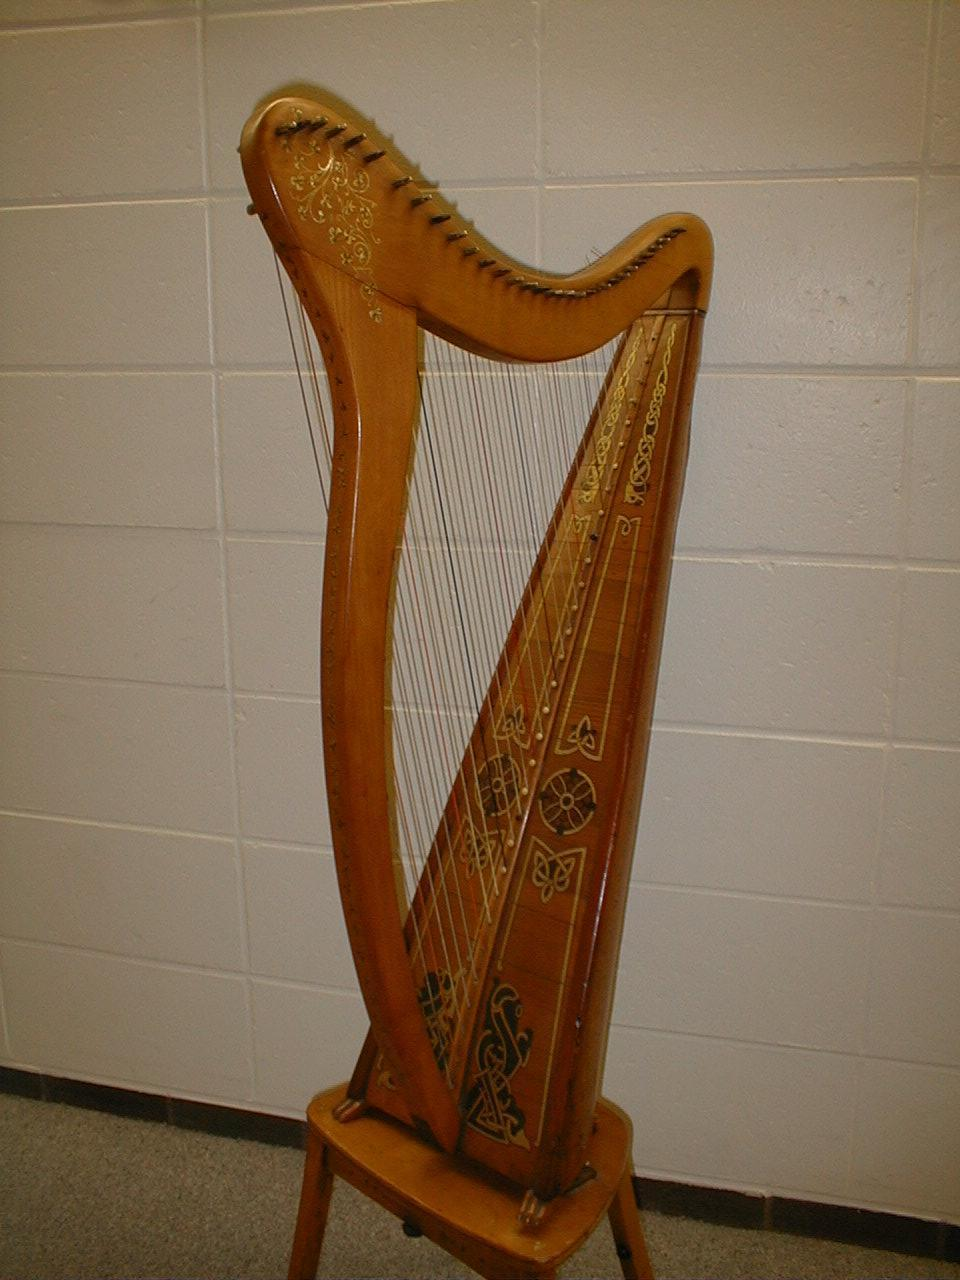

In [57]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/098.harp/098_0026.jpg"
input_image44 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image44)[0]))

img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

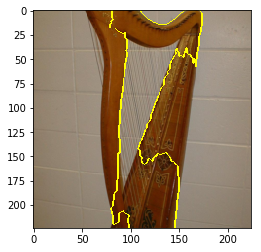

In [28]:
explainer = lime_image.LimeImageExplainer()
explanation44 = explainer.explain_instance(np.array(pill_transf(input_image44)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation44.get_image_and_mask(explanation44.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [ ]:
temp, mask = explanation44.get_image_and_mask(explanation51.top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img44 = mark_boundaries(temp/255.0, mask)
output44 = output_image(img44)

## 4.5. True label - harp ; Predicted label - harp

Prediction of MobileNet: harp


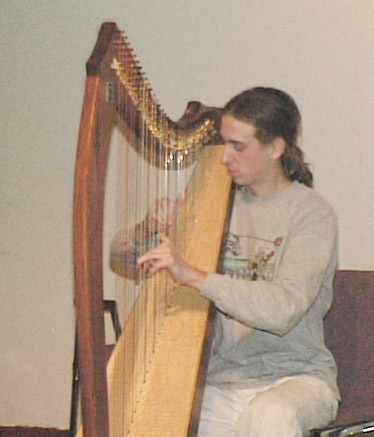

In [35]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/098.harp/098_0031.jpg"
input_image45 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image45)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

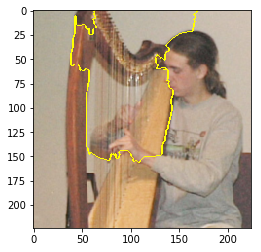

In [36]:
explainer = lime_image.LimeImageExplainer()
explanation45 = explainer.explain_instance(np.array(pill_transf(input_image45)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation45.get_image_and_mask(explanation45.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [ ]:
temp, mask = explanation45.get_image_and_mask(explanation51.top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img45 = mark_boundaries(temp/255.0, mask)
output45 = output_image(img45)

## 5. Examples of the 5 worst classifications 

## 5.1. True label - canoe ; Predicted label - Thatch, thatches roof

Prediction of MobileNet: thatch, thatched roof


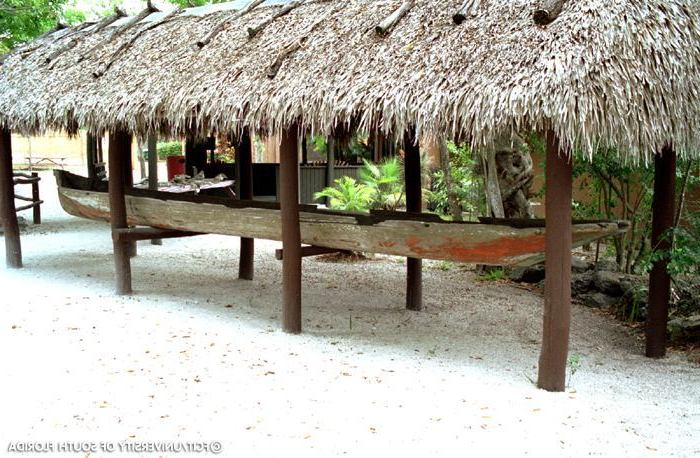

In [119]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/030.canoe/030_0086.jpg"
input_image51 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image51)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

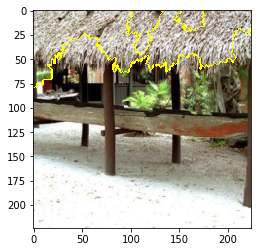

In [128]:
explainer = lime_image.LimeImageExplainer()
explanation51 = explainer.explain_instance(np.array(pill_transf(input_image51)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation51.get_image_and_mask(explanation51.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

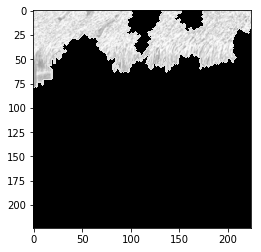

In [205]:
temp, mask = explanation51.get_image_and_mask(explanation51.top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img51 = mark_boundaries(temp/255.0, mask)
output51 = output_image(img51)

## 5.2. True label - rifle ; Predicted label - hartbeest

Prediction of MobileNet: hartebeest


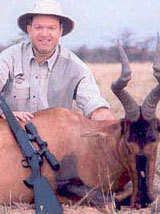

In [49]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/173.rifle/173_0030.jpg"
input_image52 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image52)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

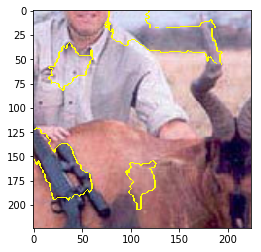

In [50]:
explainer = lime_image.LimeImageExplainer()
explanation52 = explainer.explain_instance(np.array(pill_transf(input_image52)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation52.get_image_and_mask(explanation52.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [ ]:
temp, mask = explanation52.get_image_and_mask(explanation52.top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img52 = mark_boundaries(temp/255.0, mask)
output52 = output_image(img52)

## 5.3. True label - hummingbird ; Predicted label - little blue heron, egretta caerulea

Prediction of MobileNet: little blue heron, Egretta caerulea


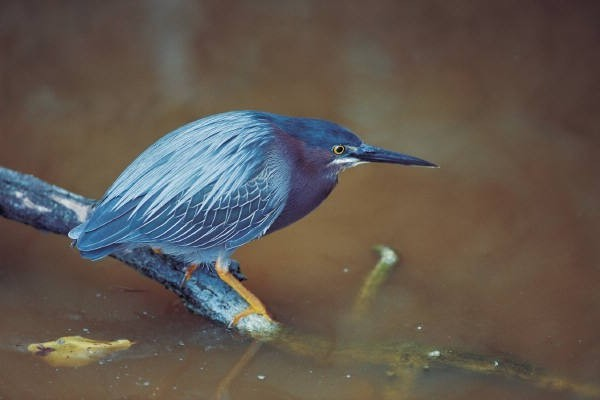

In [38]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/113.hummingbird/113_0080.jpg"
input_image53 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image53)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

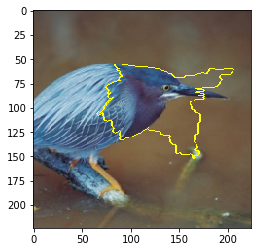

In [51]:
explainer = lime_image.LimeImageExplainer()
explanation53 = explainer.explain_instance(np.array(pill_transf(input_image53)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation53.get_image_and_mask(explanation53.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [ ]:
temp, mask = explanation53.get_image_and_mask(explanation52.top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img53 = mark_boundaries(temp/255.0, mask)
output53 = output_image(img53)

## 5.4. True label - Mushroom ; Predicted label - coho, choe, coho salmon, blue jack, silver salmon, onchorhynchus kisutch

Prediction of MobileNet: coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch


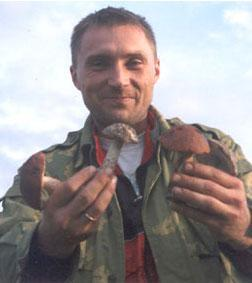

In [52]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/147.mushroom/147_0064.jpg"
input_image54 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image54)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

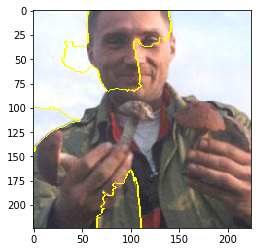

In [53]:
explainer = lime_image.LimeImageExplainer()
explanation54 = explainer.explain_instance(np.array(pill_transf(input_image54)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation54.get_image_and_mask(explanation54.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [ ]:
temp, mask = explanation54.get_image_and_mask(explanation54.top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img54 = mark_boundaries(temp/255.0, mask)
output54 = output_image(img54)

## 5.5. True label - soccer ball ; Predicted label - ocarina, sweet potato

Prediction of MobileNet: ocarina, sweet potato


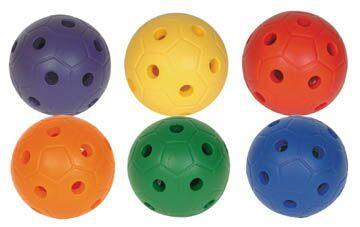

In [54]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/193.soccer-ball/193_0094.jpg"
input_image55 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image55)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

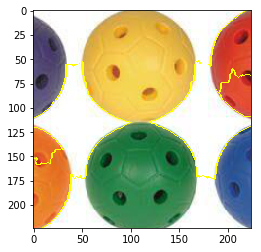

In [55]:
explainer = lime_image.LimeImageExplainer()
explanation55 = explainer.explain_instance(np.array(pill_transf(input_image55)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation55.get_image_and_mask(explanation55.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

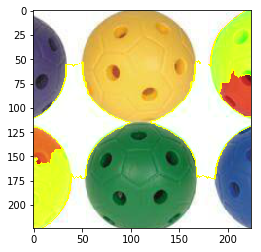

In [56]:
temp, mask = explanation55.get_image_and_mask(explanation55.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [ ]:
temp, mask = explanation55.get_image_and_mask(explanation61.top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img55 = mark_boundaries(temp/255.0, mask)
output55 = output_image(img55)

## 1.canhao 

Prediction of MobileNet: cannon


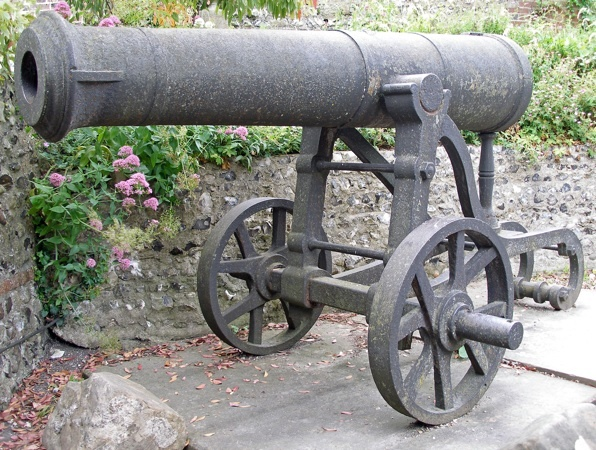

In [9]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/029.cannon/029_0033.jpg"
input_image61 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image61)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

In [ ]:
explainer = lime_image.LimeImageExplainer()
explanation61 = explainer.explain_instance(np.array(pill_transf(input_image61)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation61.get_image_and_mask(explanation61.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [ ]:
temp, mask = explanation61.get_image_and_mask(explanation61.top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img61 = mark_boundaries(temp/255.0, mask)
output61 = output_image(img61)

# 2. centipede

Prediction of MobileNet: centipede


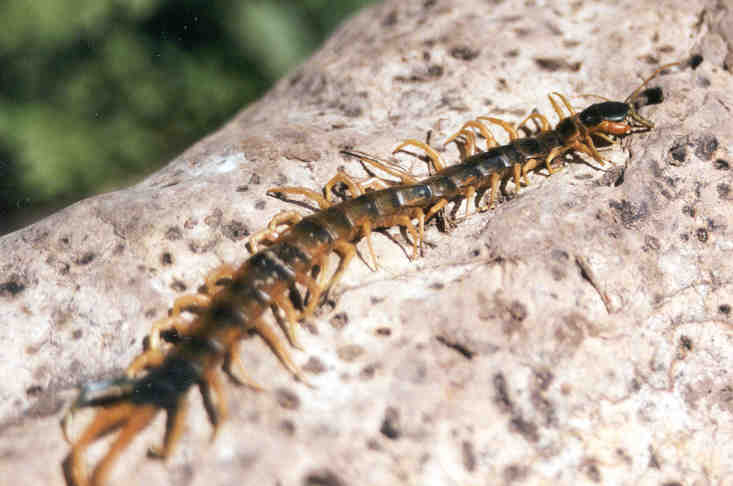

In [11]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/034.centipede/034_0036.jpg"
input_image62 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image62)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

In [ ]:
explainer = lime_image.LimeImageExplainer()
explanation62 = explainer.explain_instance(np.array(pill_transf(input_image62)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation62.get_image_and_mask(explanation62.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [ ]:
temp, mask = explanation62.get_image_and_mask(explanation62.top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img62 = mark_boundaries(temp/255.0, mask)
output62 = output_image(img62)

# 3.golf ball

Prediction of MobileNet: golf ball


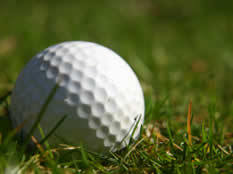

In [17]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/088.golf-ball/088_0092.jpg"
input_image63 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image63)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

In [ ]:
explainer = lime_image.LimeImageExplainer()
explanation63 = explainer.explain_instance(np.array(pill_transf(input_image63)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation63.get_image_and_mask(explanation63.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [ ]:
temp, mask = explanation63.get_image_and_mask(explanation63.top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img63 = mark_boundaries(temp/255.0, mask)
output63 = output_image(img63)

# 4. football helmet

Prediction of MobileNet: football helmet


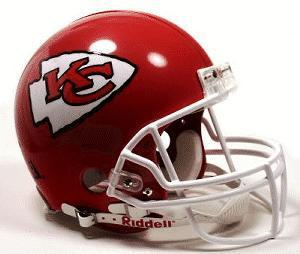

In [18]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/076.football-helmet/076_0045.jpg"
input_image64 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image64)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

In [ ]:
explainer = lime_image.LimeImageExplainer()
explanation64 = explainer.explain_instance(np.array(pill_transf(input_image64)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation64.get_image_and_mask(explanation64.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [ ]:
temp, mask = explanation64.get_image_and_mask(explanation64.top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img64 = mark_boundaries(temp/255.0, mask)
output64 = output_image(img64)

# 5. canhao

Prediction of MobileNet: cannon


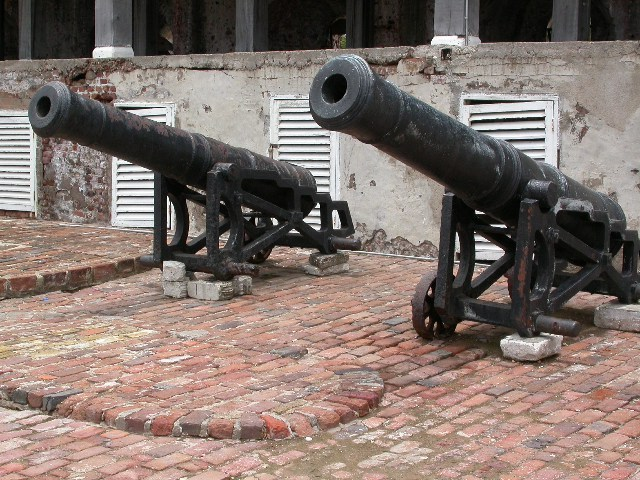

In [23]:
filename = "C:/Users/Asus/Documents/IST/MECD 0101/AEP/Projeto/32 categories/029.cannon/029_0084.jpg"
input_image65 = Image.open(filename)
print("Prediction of MobileNet: {}".format(predict(pill_transf, preprocess_transform, input_image65)[0]))
img_big = show_img(filename=filename,retina=True)
show_img(img_big.data,width=img_big.width/2)

In [ ]:
explainer = lime_image.LimeImageExplainer()
explanation65 = explainer.explain_instance(np.array(pill_transf(input_image65)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
temp, mask = explanation65.get_image_and_mask(explanation65.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [ ]:
temp, mask = explanation65.get_image_and_mask(explanation65.top_labels[0], positive_only=False, num_features=5, hide_rest=True)
img65 = mark_boundaries(temp/255.0, mask)
output65 = output_image(img65)